In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import GridSearchCV
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import (
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    roc_auc_score,
    ConfusionMatrixDisplay,
)

In [60]:
# Classification: Can we predict whether a particular car model will be a "best-seller" (yes/no) based on
# features, historical sales data, and marketing efforts.
file_path = "../data/processed/car_sales_data_with_synthetic_features.csv"
df = pd.read_csv(file_path)

print(df.info())
df.head(3)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23906 entries, 0 to 23905
Data columns (total 19 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   Car_id            23906 non-null  object
 1   Date              23906 non-null  object
 2   Customer Name     23905 non-null  object
 3   Gender            23906 non-null  object
 4   Annual Income     23906 non-null  int64 
 5   Dealer_Name       23906 non-null  object
 6   Company           23906 non-null  object
 7   Model             23906 non-null  object
 8   Engine            23906 non-null  object
 9   Transmission      23906 non-null  object
 10  Color             23906 non-null  object
 11  Price ($)         23906 non-null  int64 
 12  Dealer_No         23906 non-null  object
 13  Body Style        23906 non-null  object
 14  Phone             23906 non-null  int64 
 15  Dealer_Region     23906 non-null  object
 16  Mileage_km_total  23906 non-null  int64 
 17  Crash_Test_S

,Car_id,Date,Customer Name,Gender,Annual Income,Dealer_Name,Company,Model,Engine,Transmission,Color,Price ($),Dealer_No,Body Style,Phone,Dealer_Region,Mileage_km_total,Crash_Test_Score,Family_Size
0,C_CND_000001,1/2/2022,Geraldine,Male,13500,Buddy Storbeck's Diesel Service Inc,Ford,Expedition,DoubleÂ Overhead Camshaft,Auto,Black,26000,06457-3834,SUV,8264678,Middletown,68468,4,2
1,C_CND_000002,1/2/2022,Gia,Male,1480000,C & M Motors Inc,Dodge,Durango,DoubleÂ Overhead Camshaft,Auto,Black,19000,60504-7114,SUV,6848189,Aurora,64053,3,2
2,C_CND_000003,1/2/2022,Gianna,Male,1035000,Capitol KIA,Cadillac,Eldorado,Overhead Camshaft,Manual,Red,31500,38701-8047,Passenger,7298798,Greenville,24942,5,3


In [61]:
# Extract year and month from the 'date' column
df["Date"] = pd.to_datetime(df["Date"])
df['year'] = df['Date'].dt.year
df['month'] = df['Date'].dt.month

# Combine company and model into a single 'Model' column
df["Full_Model"] = df["Company"] + " " + df["Model"]

# Select relevant features for classification
features = [
    "year",
    "month",
    "Full_Model",
    "Engine",
    "Transmission",
    "Color",
    "Body Style",
    "Mileage_km_total",
    "Crash_Test_Score",
    "Family_Size",
]

df = df[features]

# Rename columns for clarity
df2 = df.rename(
    columns={
        "Full_Model": "full_model",
        "Engine": "engine",
        "Transmission": "transmission",
        "Color": "color",
        "Body Style": "body_style",
        "Mileage_km_total": "mileage_km",
        "Crash_Test_Score": "crash_test_score",
        "Family_Size": "family_size",
    }
)

# Parse types of features
df2 = df2.astype(
    {
        "year": "int",
        "month": "int",
        "crash_test_score": "int",
        "family_size": "int",
        "mileage_km": "int",
    }
)

print(df2.info())
df2.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23906 entries, 0 to 23905
Data columns (total 10 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   year              23906 non-null  int64 
 1   month             23906 non-null  int64 
 2   full_model        23906 non-null  object
 3   engine            23906 non-null  object
 4   transmission      23906 non-null  object
 5   color             23906 non-null  object
 6   body_style        23906 non-null  object
 7   mileage_km        23906 non-null  int64 
 8   crash_test_score  23906 non-null  int64 
 9   family_size       23906 non-null  int64 
dtypes: int64(5), object(5)
memory usage: 1.8+ MB
None


,year,month,full_model,engine,transmission,color,body_style,mileage_km,crash_test_score,family_size
0,2022,1,Ford Expedition,DoubleÂ Overhead Camshaft,Auto,Black,SUV,68468,4,2
1,2022,1,Dodge Durango,DoubleÂ Overhead Camshaft,Auto,Black,SUV,64053,3,2
2,2022,1,Cadillac Eldorado,Overhead Camshaft,Manual,Red,Passenger,24942,5,3
3,2022,1,Toyota Celica,Overhead Camshaft,Manual,Pale White,SUV,108673,3,3
4,2022,1,Acura TL,DoubleÂ Overhead Camshaft,Auto,Red,Hatchback,51660,4,1


In [62]:
# Add a new feature to indicate if the car model is a best-seller
# For simplicity, let's assume a model is a best-seller if it is in top 3 models sold in a given year and month.

# Aggregate by year, month, and full_model to get total number of sales
df2_agg = (
    df2.groupby(["year", "month", "full_model"])["year"].count().reset_index(name="total_sales")
)
# Find rank of each full_model within a year and a month based on total_sales
df2_agg["rank"] = df2_agg.groupby(["year", "month"])["total_sales"].rank(method="first", ascending=False)
df2_agg["monthly_best_seller"] = (df2_agg["rank"] <= 3).astype(int)
df2_agg.drop(columns=["rank", "total_sales"], inplace=True)

# Merge the aggregated data back to the original DataFrame
df3 = df2.merge(df2_agg, on=["year", "month", "full_model"], how="left")

df3.head()

,year,month,full_model,engine,transmission,color,body_style,mileage_km,crash_test_score,family_size,monthly_best_seller
0,2022,1,Ford Expedition,DoubleÂ Overhead Camshaft,Auto,Black,SUV,68468,4,2,0
1,2022,1,Dodge Durango,DoubleÂ Overhead Camshaft,Auto,Black,SUV,64053,3,2,0
2,2022,1,Cadillac Eldorado,Overhead Camshaft,Manual,Red,Passenger,24942,5,3,1
3,2022,1,Toyota Celica,Overhead Camshaft,Manual,Pale White,SUV,108673,3,3,0
4,2022,1,Acura TL,DoubleÂ Overhead Camshaft,Auto,Red,Hatchback,51660,4,1,0


In [63]:
# Prepare data for model training and testing

test_cond = (df3["year"] == 2023) & (df3["month"] >= 10)
train_df = df3[~test_cond]
test_df = df3[test_cond]
X_train = train_df.drop(columns=["monthly_best_seller"])
y_train = train_df["monthly_best_seller"]
X_test = test_df.drop(columns=["monthly_best_seller"])
y_test = test_df["monthly_best_seller"]

print("Shapes:")
print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

dist = np.bincount(y_train)
print("\nClass distribution:", dist)
print("First class:", 100 - dist[1] / dist[0] * 100)
print("Second class:", dist[1] / dist[0] * 100)

Shapes:
(19140, 10) (19140,)
(4766, 10) (4766,)

Class distribution: [17935  1205]
First class: 93.28129356007805
Second class: 6.71870643992194


In [ ]:
numeric_features = ["year", "month", "mileage_km", "crash_test_score", "family_size"]
categorical_features = ["full_model", "engine", "transmission", "color", "body_style"]
weights = compute_class_weight(
    class_weight="balanced", classes=np.unique(y_train), y=y_train
)
class_weights = dict(zip(np.unique(y_train), weights))

In [ ]:
pipeline_1 = Pipeline(
    [
        (
            "preprocessor",
            ColumnTransformer(
                [
                    ("num", Pipeline([("scaler", StandardScaler())]), numeric_features),
                    (
                        "cat",
                        Pipeline([("onehot", OneHotEncoder(handle_unknown="ignore"))]),
                        categorical_features,
                    ),
                ]
            ),
        ),
        ("classifier", LogisticRegression(max_iter=1000, class_weight=class_weights)),
    ]
)
pipeline_1

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('scaler',
                                                                   StandardScaler())]),
                                                  ['year', 'month',
                                                   'mileage_km',
                                                   'crash_test_score',
                                                   'family_size']),
                                                 ('cat',
                                                  Pipeline(steps=[('onehot',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  ['full_model', 'engine',
                                                   'transmission', 'color',
                                                   'body_style'])])),
                ('classifier',
                 LogisticRegression(class_weight={0: 0.5335935321996097,
                                                  1: 7.941908713692946},
                                    max_iter=1000))])

In [ ]:
pipeline_2 = Pipeline(
    [
        (
            "preprocessor",
            ColumnTransformer(
                [
                    (
                        "cat",
                        Pipeline([("onehot", OneHotEncoder(handle_unknown="ignore"))]),
                        categorical_features,
                    ),
                ]
            ),
        ),
        ("classifier", LogisticRegression(max_iter=1000, class_weight=class_weights)),
    ]
)
pipeline_2

In [ ]:
def grid_search_pipeline(pipeline):
    param_grid = {
        # Logistic Regression hyperparameters
        "classifier__C": [0.01, 0.1, 1, 10, 100],
        "classifier__penalty": ["l2", "l1"],
        "classifier__solver": ["liblinear", "lbfgs", "saga"],
        "classifier__fit_intercept": [True, False],
        "classifier__class_weight": [
            class_weights,
            "balanced",
            None,
        ],  # Try letting model auto-balance too
        # OneHotEncoder hyperparameters
        "preprocessor__cat__onehot__drop": [
            "first",
            None,
        ],  # Drop first column to avoid collinearity
        "preprocessor__cat__onehot__sparse": [
            False
        ],  # Dense matrix for compatibility/performance
    }
    grid = GridSearchCV(pipeline, param_grid, scoring="roc_auc", cv=5)
    grid.fit(X_train, y_train)

    print("Best params:", grid.best_params_)
    print("Best AUC:", grid.best_score_)
    return grid.best_estimator_

Best params: {'classifier__C': 0.1, 'classifier__class_weight': 'balanced', 'classifier__penalty': 'l2', 'classifier__solver': 'lbfgs', 'preprocessor__cat__onehot__drop': None}
Best AUC: 0.9339327007277317


In [ ]:
def evaluate_model(model):
    y_pred = model.predict(X_test)

    # Predict probabilities (for ROC, AUC, etc.)
    y_proba = model.predict_proba(X_test)[:, 1]

    print("Accuracy:", accuracy_score(y_test, y_pred))
    print("Precision:", precision_score(y_test, y_pred))
    print("Recall:", recall_score(y_test, y_pred))
    print("F1 Score:", f1_score(y_test, y_pred))
    print("AUC:", roc_auc_score(y_test, y_proba))
    ConfusionMatrixDisplay.from_predictions(y_test, y_pred)

In [ ]:
model_1 = grid_search_pipeline(pipeline_1)
evaluate_model(model_1)

Accuracy: 0.9018044481745698
Precision: 0.3718120805369127
Recall: 1.0
F1 Score: 0.5420743639921722
AUC: 0.9747211997558412


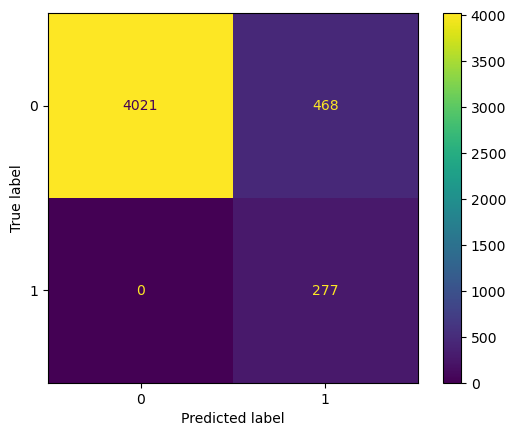

In [ ]:
model_2 = grid_search_pipeline(pipeline_2)
evaluate_model(model_2)